# Deep learning for image classification


Let's train network to classify images from Tiny ImageNet!

Notebook contain of three parts:

1. Ordinary training script structure and train good old vgg-like network
2. Improve quality with resnet-like network
3. Improve quality with test-time augmentation

But first of all let's take a look on data

# Tiny ImageNet dataset
We shall focus on the image recognition problem on Tiny Image Net dataset. This dataset contains
* 100k images of shape 3x64x64
* 200 different classes: snakes, spiders, cats, trucks, grasshopper, gull, etc.

In fact, it is a subset of ImageNet dataset with 4x downscaled images.

## Image examples



<tr>
    <td> <img src="https://github.com/yandexdataschool/Practical_DL/blob/sem3spring2019/week03_convnets/tinyim3.png?raw=1" alt="Drawing" style="width:90%"/> </td>
    <td> <img src="https://github.com/yandexdataschool/Practical_DL/blob/sem3spring2019/week03_convnets/tinyim2.png?raw=1" alt="Drawing" style="width:90%"/> </td>
</tr>


<tr>
    <td> <img src="https://github.com/yandexdataschool/Practical_DL/blob/sem3spring2019/week03_convnets/tiniim.png?raw=1" alt="Drawing" style="width:90%"/> </td>
</tr>

## Step 0 - data loading

In [1]:
#!S:bash
!wget --no-check-certificate 'https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img.py' -O tiny_img.py
!wget --no-check-certificate 'https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img_dataset.py' -O tiny_img_dataset.py

--2023-09-29 08:20:14--  https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 813 [text/plain]
Saving to: ‘tiny_img.py’

tiny_img.py         100%[===================>]     813  --.-KB/s    in 0s      

2023-09-29 08:20:14 (64.1 MB/s) - ‘tiny_img.py’ saved [813/813]

--2023-09-29 08:20:14--  https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img_dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response

In [2]:
#!L
from tiny_img import download_tinyImg200
data_path = '.'
download_tinyImg200(data_path)

Dataset was downloaded to './tiny-imagenet-200.zip'
Extract downloaded dataset to '.'


## Part 1. Training script structure and vgg-like network

In order to train a neural network for a specific task you should write code for 4 task-specific blocks and for one task-independed block:
1. data loader (data provider) - how to load and augment data for nn training
2. neural network architecture - what will be trained
3. loss function (+ auxilary metrics on train and validation set) - how to check neural network quality
4. optiimzer and training schedule - how neural network will be trained
5. "Train loop" - what exactly to do for each batch, how often to check validation error, how often to save network and so on. This code could be written in general way and reused between different training scripts


In [3]:
#!L
import torch
import torchvision
from torchvision import transforms
import tqdm

def get_computing_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

device = get_computing_device()
print(f"Our main computing device is '{device}'")

Our main computing device is 'cuda:0'


### 1.1 Data loader and data augmentation
Normally there are two connected abstractions for data manipulation:
- Dataset (`torch.utils.data.Dataset` and its subclasses from `torchvision.datasets`) - some black-box that keeps and preprocesses separate elements of dataset. In particular, single sample augmentations live on this level usually.
- DataLoader (`torch.utils.data.DataLoader`) - structure that combines separate elements in batch.

Let's deal with training dataset. Here are some simple augmentations that we are going to use in our experiments:

In [4]:
import cv2

In [5]:
import numpy as np
import tqdm as tqdm

In [6]:
train_trainsforms = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.RandomRotation(5),
     transforms.ColorJitter(hue=.05, saturation=.05)]
)

For training dataset we will use custom dataset that will keep all training data in RAM. If your amount of RAM memory is low, you can use `torchvision.datasets.ImageFolder()` instead.

In [7]:
#!L
import tiny_img_dataset
# you may use torchvision.datasets.ImageFolder() with the same parameters for loading train dataset
train_dataset = tiny_img_dataset.TinyImagenetRAM('tiny-imagenet-200/train', transform=train_trainsforms)

tiny-imagenet-200/train: 100%|██████████| 200/200 [01:00<00:00,  3.31it/s]


In [ ]:
train_dataset.classes[:5]

['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640']

In [ ]:
train_dataset[0]

(tensor([[[0.5004, 0.8218, 0.8176,  ..., 0.9701, 0.9927, 0.9926],
          [0.4847, 0.7943, 0.8057,  ..., 0.9580, 0.9883, 0.9920],
          [0.4729, 0.7943, 0.8135,  ..., 0.9927, 0.9923, 0.9921],
          ...,
          [0.3677, 0.3050, 0.3324,  ..., 0.3625, 0.3625, 0.3702],
          [0.3403, 0.3011, 0.3363,  ..., 0.3468, 0.3468, 0.3467],
          [0.2814, 0.3011, 0.3756,  ..., 0.3625, 0.3547, 0.3546]],
 
         [[0.6382, 0.9442, 0.9286,  ..., 0.5761, 0.5451, 0.5373],
          [0.6225, 0.9167, 0.9051,  ..., 0.5410, 0.5062, 0.4985],
          [0.6068, 0.9167, 0.9130,  ..., 0.5336, 0.5103, 0.4986],
          ...,
          [0.3277, 0.2649, 0.2924,  ..., 0.4537, 0.4654, 0.4771],
          [0.3002, 0.2610, 0.2963,  ..., 0.4380, 0.4497, 0.4574],
          [0.2414, 0.2610, 0.3355,  ..., 0.4537, 0.4653, 0.4653]],
 
         [[0.6330, 0.9426, 0.9229,  ..., 0.7716, 0.7435, 0.7470],
          [0.6097, 0.9075, 0.9031,  ..., 0.7514, 0.7307, 0.7304],
          [0.5863, 0.8998, 0.9033,  ...,

Now validation. Take a look at `tiny-imagenet-200/val` folder and compare it with `tiny-imagenet-200/train`. Looks different, right? So we can't use `TinyImagenetRAM` for loading the validation set. Let's write a custom dataset instead but with the same behavior like `TinyImagenetRAM`.

In [8]:
from torch.utils.data import Dataset
import os
from PIL import Image

class TinyImagenetValDataset(Dataset):
    def __init__(self, root, transform=transforms.ToTensor()):
        super().__init__()

        self.root = root
        with open(os.path.join(root, 'val_annotations.txt')) as f:
            annotations = []
            for line in f:
                img_name, class_label = line.split('\t')[:2]
                annotations.append((img_name, class_label))

        # 1. define self.classes - list of sorted class labels from annotations
        # it should look like self.classes from "TinyImagenetRAM"
        # YOUR CODE
        self.classes = list(sorted(np.unique(np.array([item[1] for item in annotations]))))

        assert len(self.classes) == 200, len(self.classes)
        assert all(self.classes[i] < self.classes[i+1] for i in range(len(self.classes)-1)), 'classes should be ordered'
        assert all(isinstance(elem, type(annotations[0][1])) for elem in self.classes), 'your just need to reuse class_labels'

        # 2. self.class_to_idx - dict from class label to class index
        self.class_to_idx = {item: index for index, item in enumerate(self.classes)}

        self.transform = transform

        self.images, self.targets = [], []
        for img_name, class_name in tqdm.tqdm(annotations, desc=root):
            img_name = os.path.join(root, 'images', img_name)
            # 3. load image and store it in self.images (your may want to use tiny_img_dataset.read_rgb_image)
            # store the class index in self.targets
            image = tiny_img_dataset.read_rgb_image(img_name)

            assert image.shape == (64, 64, 3), image.shape
            self.images.append(Image.fromarray(image))
            self.targets.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        # take image and its target label from "self.images" and "self.targets",
        # transform the image using self.transform and return the transformed image and its target label

        image = self.transform(self.images[index])
        target = self.targets[index]
        return image, target

Let's finally load validation dataset. Normally you don't need to augment validation data.

In [9]:
val_dataset = TinyImagenetValDataset('tiny-imagenet-200/val', transform=transforms.ToTensor())

assert all(train_dataset.classes[i] == val_dataset.classes[i] for i in range(200)), \
    'class order in train and val datasets should be the same'
assert all(train_dataset.class_to_idx[elem] == val_dataset.class_to_idx[elem] for elem in train_dataset.classes), \
    'class indices should be the same'

tiny-imagenet-200/val: 100%|██████████| 10000/10000 [00:07<00:00, 1419.36it/s]


In [ ]:
val_dataset[0]

(tensor([[[0.1490, 0.7137, 0.7922,  ..., 0.6078, 0.5451, 0.5216],
          [0.0392, 0.0275, 0.2392,  ..., 0.5098, 0.4627, 0.4745],
          [0.7647, 0.8078, 0.4000,  ..., 0.5059, 0.3843, 0.4235],
          ...,
          [0.2078, 0.2196, 0.2588,  ..., 0.6980, 0.7176, 0.6941],
          [0.1647, 0.1216, 0.1137,  ..., 0.7059, 0.7333, 0.7216],
          [0.6196, 0.5882, 0.5961,  ..., 0.6784, 0.7255, 0.7216]],
 
         [[0.1922, 0.7137, 0.7059,  ..., 0.6196, 0.5647, 0.5412],
          [0.1098, 0.0549, 0.1765,  ..., 0.5255, 0.4784, 0.4941],
          [0.8863, 0.8863, 0.3882,  ..., 0.5216, 0.4000, 0.4510],
          ...,
          [0.2078, 0.2196, 0.2588,  ..., 0.6941, 0.7137, 0.6902],
          [0.1608, 0.1176, 0.1098,  ..., 0.7020, 0.7294, 0.7176],
          [0.6157, 0.5843, 0.5922,  ..., 0.6745, 0.7216, 0.7176]],
 
         [[0.2078, 0.7451, 0.7569,  ..., 0.5529, 0.4863, 0.4627],
          [0.1176, 0.0784, 0.2196,  ..., 0.4588, 0.4118, 0.4157],
          [0.8667, 0.8824, 0.4157,  ...,

For the most cases the default `DataLoader` will be good enough.

In [10]:
#!L
batch_size = 64
train_batch_gen = torch.utils.data.DataLoader(train_dataset,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=12)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:
#!L
val_batch_gen = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=batch_size,
                                            shuffle=False,
                                            num_workers=12)

### 1.2 Neural network definition

"VGG-like network" usually means that the network is a sequence of convolutions with MaxPooling for downsampling. Here is a table from the original paper ["Very Deep Convolutional Networks for Large-Scale Image Recognition"](https://arxiv.org/abs/1409.1556) that describes classical configurations of VGG networks (often referred as VGG-A, VGG-B and so on using column name as an identificator or as VGG16, VGG19 and so on using amount of layers as an identificator)
![image.png](https://pytorch.org/assets/images/vgg.png)

These network configurations were designed for ImageNet dataset. Since images in tiny-imagenet are 4x downsampled, we are going to design our own configuration by reducing: 1) amount of layers; 2) amount of neurons in layers; 3) amount of maxpooling layers which downsample feature maps

Our network config will be [Conv(16), Conv(16), MaxPool] + [Conv(32), Conv(32), MaxPool] + [Conv(64), Conv(64), MaxPool] + [Conv(128), Conv(128)] + [GlobalAveragePooling] + [FC(200) + softmax]

We use Conv(128) and GlobalAveragePooling instead of image flattening and FC layers for reducing the amount of parameters.

In [12]:
#!L
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

And one more thing. VGG was designed before BatchNormalization was introduced. Nowadays it will be stupid if we don't use batch normalization in our network. So let's define simple module containing convolution, batch norm and relu in it and build our network using this module. Here is also implementation of GlobalAveragePooling given for you as example of custom module.

In [13]:
#!L
class GlobalAveragePool(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, x):
        return torch.mean(x, dim=self.dim)


class ConvBNRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding='same'):
        super().__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn(self.conv(x)))
        return x


def create_vgg_like_network(config=None):
    """
    Creates VGG like network according to config
    """
    model = nn.Sequential()

    default_config = [[16,16], [32, 32], [64, 64], [128, 128]]
    config = config or default_config

    in_channels = 3
    for block_index in range(len(config)):
        for layer_index_in_block in range(len(config[block_index])):
            out_channels = config[block_index][layer_index_in_block]

            model.add_module('ConvBNRelu' + str(2 * block_index + layer_index_in_block), ConvBNRelu(in_channels, out_channels, 3))

            in_channels = out_channels

        if block_index != len(config) - 1:
            model.add_module(f'mp_{block_index}', nn.MaxPool2d(3, stride=2))

    model.add_module('pool', GlobalAveragePool(dim=(2,3)))
    model.add_module('logits', nn.Linear(out_channels, 200))
    return model

Here are our model created!

In [ ]:
model = create_vgg_like_network()
model = model.to(device)

In [ ]:
model

Sequential(
  (ConvBNRelu0): ConvBNRelu(
    (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (ConvBNRelu1): ConvBNRelu(
    (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (mp_0): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (ConvBNRelu2): ConvBNRelu(
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (ConvBNRelu3): ConvBNRelu(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (mp_1): MaxPool2d(kernel_size=

### 1.3 Loss function definition

Usually cross-entropy (negative log-likelihood) is used as loss function for image classification.

In [14]:
#!L
def compute_loss(predictions, gt):
    return F.cross_entropy(predictions, gt).mean()

### 1.4 Optimizer and training schedule

Let's train our network using Adam with default parameters.

For training by `torch.optim.SGD` you usually have to define training schedule - a way how to decrease learning rate during training. But since in adam all the gradients are scaled on their second momentum, the effect of a good training schedule is not so critical for training as in SGD. So we are going to act like lazy data scientists and will not decrease learning rate at all. But you may play with scheduling using for example `torch.optim.lr_scheduler.ExponentialLR`, see the [documentation](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) with explanation how to use it.

In [ ]:
opt = torch.optim.Adam(model.parameters())

### 1.5 Training loop

Let's combine the previously defined things together.

In [15]:
import numpy as np
import time


def eval_model(model, data_generator):
    accuracy = []
    model.train(False) # disable dropout / use averages for batch_norm
    with torch.no_grad():
        for X_batch, y_batch in data_generator:
            X_batch = X_batch.to(device)
            logits = model(X_batch)
            y_pred = logits.max(1)[1].data
            accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))
    return np.mean(accuracy)


def train_model(model, optimizer, train_data_generator):
    train_loss = []
    model.train(True) # enable dropout / batch_norm training behavior
    for (X_batch, y_batch) in tqdm.tqdm(train_data_generator):
        opt.zero_grad()

        # forward
        # run `compute_loss()` function
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        predictions = model(X_batch)
        loss = compute_loss(predictions, y_batch)

        # backward
        loss.backward()
        optimizer.step()

        # metrics
        train_loss.append(loss.cpu().data.numpy())
    return np.mean(train_loss)


def train_loop(model, optimizer, train_data_generator, val_data_generator, num_epochs):
    """
    num_epochs - total amount of full passes over training data
    """
    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss = train_model(model, optimizer, train_data_generator)

        val_accuracy = eval_model(model, val_data_generator)

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_accuracy * 100))

### 1.6 Training

All the preparation is done, time to run the training!

Normally after training for 30 epochs you should get a neural network that predicts labels with >40% accuracy here.

In [ ]:
train_loop(model, opt, train_batch_gen, val_batch_gen, num_epochs=30)

100%|██████████| 1563/1563 [03:54<00:00,  6.67it/s]


Epoch 1 of 30 took 237.404s
  training loss (in-iteration): 	4.306394
  validation accuracy: 			12.34 %


100%|██████████| 1563/1563 [03:40<00:00,  7.10it/s]


Epoch 2 of 30 took 223.205s
  training loss (in-iteration): 	3.598717
  validation accuracy: 			20.53 %


100%|██████████| 1563/1563 [03:41<00:00,  7.06it/s]


Epoch 3 of 30 took 224.371s
  training loss (in-iteration): 	3.274896
  validation accuracy: 			26.06 %


100%|██████████| 1563/1563 [03:35<00:00,  7.26it/s]


Epoch 4 of 30 took 218.418s
  training loss (in-iteration): 	3.067169
  validation accuracy: 			28.11 %


100%|██████████| 1563/1563 [03:43<00:00,  6.99it/s]


Epoch 5 of 30 took 226.686s
  training loss (in-iteration): 	2.917248
  validation accuracy: 			29.75 %


100%|██████████| 1563/1563 [03:41<00:00,  7.05it/s]


Epoch 6 of 30 took 226.194s
  training loss (in-iteration): 	2.807949
  validation accuracy: 			30.56 %


100%|██████████| 1563/1563 [03:38<00:00,  7.16it/s]


Epoch 7 of 30 took 221.141s
  training loss (in-iteration): 	2.716479
  validation accuracy: 			33.79 %


100%|██████████| 1563/1563 [03:37<00:00,  7.18it/s]


Epoch 8 of 30 took 221.538s
  training loss (in-iteration): 	2.641048
  validation accuracy: 			34.65 %


100%|██████████| 1563/1563 [03:58<00:00,  6.56it/s]


Epoch 9 of 30 took 241.376s
  training loss (in-iteration): 	2.569232
  validation accuracy: 			35.97 %


100%|██████████| 1563/1563 [03:38<00:00,  7.14it/s]


Epoch 10 of 30 took 223.417s
  training loss (in-iteration): 	2.510348
  validation accuracy: 			36.01 %


100%|██████████| 1563/1563 [03:37<00:00,  7.20it/s]


Epoch 11 of 30 took 220.202s
  training loss (in-iteration): 	2.460958
  validation accuracy: 			37.77 %


100%|██████████| 1563/1563 [03:35<00:00,  7.26it/s]


Epoch 12 of 30 took 218.196s
  training loss (in-iteration): 	2.414044
  validation accuracy: 			37.69 %


100%|██████████| 1563/1563 [03:37<00:00,  7.20it/s]


Epoch 13 of 30 took 220.118s
  training loss (in-iteration): 	2.370878
  validation accuracy: 			37.53 %


100%|██████████| 1563/1563 [03:37<00:00,  7.20it/s]


Epoch 14 of 30 took 221.292s
  training loss (in-iteration): 	2.332641
  validation accuracy: 			39.16 %


100%|██████████| 1563/1563 [03:35<00:00,  7.26it/s]


Epoch 15 of 30 took 218.436s
  training loss (in-iteration): 	2.293627
  validation accuracy: 			40.49 %


100%|██████████| 1563/1563 [03:37<00:00,  7.19it/s]


Epoch 16 of 30 took 220.417s
  training loss (in-iteration): 	2.262292
  validation accuracy: 			39.47 %


100%|██████████| 1563/1563 [03:30<00:00,  7.44it/s]


Epoch 17 of 30 took 213.116s
  training loss (in-iteration): 	2.228473
  validation accuracy: 			40.16 %


100%|██████████| 1563/1563 [03:29<00:00,  7.46it/s]


Epoch 18 of 30 took 212.969s
  training loss (in-iteration): 	2.200428
  validation accuracy: 			41.60 %


100%|██████████| 1563/1563 [03:33<00:00,  7.31it/s]


Epoch 19 of 30 took 217.225s
  training loss (in-iteration): 	2.172321
  validation accuracy: 			41.24 %


100%|██████████| 1563/1563 [03:25<00:00,  7.62it/s]


Epoch 20 of 30 took 208.115s
  training loss (in-iteration): 	2.149545
  validation accuracy: 			42.57 %


100%|██████████| 1563/1563 [03:26<00:00,  7.56it/s]


Epoch 21 of 30 took 210.489s
  training loss (in-iteration): 	2.123828
  validation accuracy: 			42.14 %


100%|██████████| 1563/1563 [03:29<00:00,  7.46it/s]


Epoch 22 of 30 took 212.820s
  training loss (in-iteration): 	2.103640
  validation accuracy: 			41.45 %


100%|██████████| 1563/1563 [03:26<00:00,  7.58it/s]


Epoch 23 of 30 took 210.286s
  training loss (in-iteration): 	2.079353
  validation accuracy: 			42.51 %


100%|██████████| 1563/1563 [03:23<00:00,  7.67it/s]


Epoch 24 of 30 took 206.833s
  training loss (in-iteration): 	2.060135
  validation accuracy: 			42.29 %


100%|██████████| 1563/1563 [03:25<00:00,  7.61it/s]


Epoch 25 of 30 took 208.242s
  training loss (in-iteration): 	2.043202
  validation accuracy: 			42.65 %


100%|██████████| 1563/1563 [03:24<00:00,  7.63it/s]


Epoch 26 of 30 took 208.388s
  training loss (in-iteration): 	2.022444
  validation accuracy: 			42.95 %


100%|██████████| 1563/1563 [03:28<00:00,  7.50it/s]


Epoch 27 of 30 took 211.646s
  training loss (in-iteration): 	2.004122
  validation accuracy: 			43.63 %


100%|██████████| 1563/1563 [03:25<00:00,  7.62it/s]


Epoch 28 of 30 took 208.032s
  training loss (in-iteration): 	1.991219
  validation accuracy: 			43.35 %


100%|██████████| 1563/1563 [03:25<00:00,  7.62it/s]


Epoch 29 of 30 took 208.953s
  training loss (in-iteration): 	1.972294
  validation accuracy: 			42.71 %


100%|██████████| 1563/1563 [03:23<00:00,  7.67it/s]


Epoch 30 of 30 took 206.944s
  training loss (in-iteration): 	1.955864
  validation accuracy: 			43.57 %


Даже за 15 итераций выбили нужное качество, лучшее за 30 эпох: 43.63% accuracy (думаю, это не предел данной архитектуры, так как можно еще более точно сойтись с меньшим шагом, то есть после обучения выше еще дообучить с меньшим шагом)

## Part 2. Say Hello to ResNets

In this part you need to redefine your model, all the rest will be the same. As with VGG, we are going to define ResNet-like model, not a classic architecture, designed for ImageNet classification.

"ResNet-like" usually means that your network consists of "residual blocks". There are two types of blocks that widely used: with two convolutions and with three convolutions

In practice, blocks with three convolutions are used often since they allows to build more deep network with less parameters. Blocks with two convolutions are usually used for comparisson with non-residual networks, espatially with VGG and AlexNet.

Here is a table from the paper "[Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)" that describes classical configurations of ResNet networks. Usually they are referred as ResNet-18, ResNet-34 and so on using amount of layers as identificator. Note, that networks starting from ResNet-50 are based on 3-convolutional blocks. In fact ResNet-18 and ResNet-34 were introduces just for comparison with VGG, while ResNet-50 is what usually used in practice as a good baseline.

As with VGG, we are going to build our own config for network. Let's use 2-convolutional blocks for comparisson with vgg and take network like [Conv7x7 - 32] + [conv32-block, conv32-block] + [conv64-block, conv64-block] + [conv128-block, conv128-block] + [GlobalAveragePooling] + fc200 + softmax

Comparing to ResNet18, we decreased the amount of filters and removed max-pooling in the beggining and the last set of convolutions for keeping meaningful spatial resolution.

In [16]:
class ResNetBlock2(nn.Module):
    """
    Module implements the following function:

    output = relu(F(input) + Residual(input)), where:
        Residual(x) = Conv + bn + relu + conv + bn
        F(x) = x                                        , if in_channels == out_channels and stride == 1
             = Conv1x1(in_channel, out_channel, stride) , otherwise
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding='same'):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu2 = nn.ReLU()

        self.conv3 = None  # conv for main branch adopatation
        if in_channels != out_channels or stride != 1:
            self.conv3 = nn.Conv2d(in_channels, out_channels, 1, stride, padding=0)

    def forward(self, x):
        residual = self.bn2(self.conv2(self.relu1(self.bn1(self.conv1(x)))))

        if self.conv3 is not None:
            x = self.conv3(x)

        result = self.relu2(residual + x)
        return result

def create_resnet_like_network():
    model = nn.Sequential()

    config = [[32, 32], [64, 64], [128, 128]]
    model.add_module('init_conv', ConvBNRelu(3, 32, kernel_size=7, stride=2, padding=3))

    in_channels = 32
    for i in range(len(config)):
        for j in range(len(config[i])):
            out_channels = config[i][j]
            stride = 2 if i != 0 and j == 0 else 1
            model.add_module('ResNetBlock' + str(2 * i + j), ResNetBlock2(in_channels, out_channels, 3))

            in_channels = out_channels
    model.add_module('pool', GlobalAveragePool((2,3)))
    model.add_module('logits', nn.Linear(out_channels, 200))
    return model

Let's train our network then. Normally after training for 30 epochs you should get a neural network that predicts labels with >40% accuracy and gives near +1% profit to vgg-like network from the previous experiment.

In [ ]:
model = create_resnet_like_network()
model = model.to(device)
opt = torch.optim.Adam(model.parameters())
train_loop(model, opt, train_batch_gen, val_batch_gen, num_epochs=30)

100%|██████████| 1563/1563 [04:04<00:00,  6.39it/s]


Epoch 1 of 30 took 250.383s
  training loss (in-iteration): 	4.673260
  validation accuracy: 			8.87 %


100%|██████████| 1563/1563 [03:55<00:00,  6.65it/s]


Epoch 2 of 30 took 240.188s
  training loss (in-iteration): 	4.040363
  validation accuracy: 			14.61 %


100%|██████████| 1563/1563 [03:54<00:00,  6.66it/s]


Epoch 3 of 30 took 240.369s
  training loss (in-iteration): 	3.699585
  validation accuracy: 			19.62 %


100%|██████████| 1563/1563 [03:53<00:00,  6.70it/s]


Epoch 4 of 30 took 238.758s
  training loss (in-iteration): 	3.453593
  validation accuracy: 			21.67 %


100%|██████████| 1563/1563 [03:51<00:00,  6.77it/s]


Epoch 5 of 30 took 236.655s
  training loss (in-iteration): 	3.255531
  validation accuracy: 			25.08 %


100%|██████████| 1563/1563 [03:54<00:00,  6.67it/s]


Epoch 6 of 30 took 239.893s
  training loss (in-iteration): 	3.094632
  validation accuracy: 			28.29 %


100%|██████████| 1563/1563 [03:54<00:00,  6.67it/s]


Epoch 7 of 30 took 239.602s
  training loss (in-iteration): 	2.964762
  validation accuracy: 			32.22 %


100%|██████████| 1563/1563 [03:55<00:00,  6.64it/s]


Epoch 8 of 30 took 240.831s
  training loss (in-iteration): 	2.853092
  validation accuracy: 			31.48 %


100%|██████████| 1563/1563 [03:51<00:00,  6.74it/s]


Epoch 9 of 30 took 237.006s
  training loss (in-iteration): 	2.754045
  validation accuracy: 			33.07 %


100%|██████████| 1563/1563 [03:49<00:00,  6.80it/s]


Epoch 10 of 30 took 235.237s
  training loss (in-iteration): 	2.672938
  validation accuracy: 			34.55 %


100%|██████████| 1563/1563 [03:40<00:00,  7.10it/s]


Epoch 11 of 30 took 225.517s
  training loss (in-iteration): 	2.597953
  validation accuracy: 			34.73 %


100%|██████████| 1563/1563 [03:36<00:00,  7.23it/s]


Epoch 12 of 30 took 221.236s
  training loss (in-iteration): 	2.535464
  validation accuracy: 			36.40 %


100%|██████████| 1563/1563 [03:35<00:00,  7.24it/s]


Epoch 13 of 30 took 220.980s
  training loss (in-iteration): 	2.474962
  validation accuracy: 			39.89 %


100%|██████████| 1563/1563 [03:36<00:00,  7.21it/s]


Epoch 14 of 30 took 222.365s
  training loss (in-iteration): 	2.417884
  validation accuracy: 			39.37 %


100%|██████████| 1563/1563 [03:33<00:00,  7.33it/s]


Epoch 15 of 30 took 218.269s
  training loss (in-iteration): 	2.372358
  validation accuracy: 			39.42 %


100%|██████████| 1563/1563 [03:41<00:00,  7.06it/s]


Epoch 16 of 30 took 226.428s
  training loss (in-iteration): 	2.323006
  validation accuracy: 			40.07 %


100%|██████████| 1563/1563 [03:36<00:00,  7.23it/s]


Epoch 17 of 30 took 221.509s
  training loss (in-iteration): 	2.287891
  validation accuracy: 			42.11 %


100%|██████████| 1563/1563 [03:35<00:00,  7.26it/s]


Epoch 18 of 30 took 220.786s
  training loss (in-iteration): 	2.240350
  validation accuracy: 			40.77 %


100%|██████████| 1563/1563 [03:36<00:00,  7.23it/s]


Epoch 19 of 30 took 221.228s
  training loss (in-iteration): 	2.208132
  validation accuracy: 			42.80 %


100%|██████████| 1563/1563 [03:32<00:00,  7.34it/s]


Epoch 20 of 30 took 218.216s
  training loss (in-iteration): 	2.172916
  validation accuracy: 			43.68 %


100%|██████████| 1563/1563 [03:36<00:00,  7.22it/s]


Epoch 21 of 30 took 221.498s
  training loss (in-iteration): 	2.137773
  validation accuracy: 			43.77 %


100%|██████████| 1563/1563 [03:39<00:00,  7.11it/s]


Epoch 22 of 30 took 224.658s
  training loss (in-iteration): 	2.108491
  validation accuracy: 			44.09 %


100%|██████████| 1563/1563 [03:38<00:00,  7.14it/s]


Epoch 23 of 30 took 224.383s
  training loss (in-iteration): 	2.076995
  validation accuracy: 			44.30 %


100%|██████████| 1563/1563 [03:34<00:00,  7.30it/s]


Epoch 24 of 30 took 219.658s
  training loss (in-iteration): 	2.049848
  validation accuracy: 			44.03 %


100%|██████████| 1563/1563 [03:37<00:00,  7.20it/s]


Epoch 25 of 30 took 222.062s
  training loss (in-iteration): 	2.021624
  validation accuracy: 			43.85 %


100%|██████████| 1563/1563 [03:40<00:00,  7.10it/s]


Epoch 26 of 30 took 225.182s
  training loss (in-iteration): 	1.999934
  validation accuracy: 			44.20 %


100%|██████████| 1563/1563 [03:41<00:00,  7.05it/s]


Epoch 27 of 30 took 226.781s
  training loss (in-iteration): 	1.974721
  validation accuracy: 			44.75 %


100%|██████████| 1563/1563 [03:43<00:00,  7.00it/s]


Epoch 28 of 30 took 228.207s
  training loss (in-iteration): 	1.951580
  validation accuracy: 			44.81 %


 25%|██▌       | 391/1563 [00:58<02:50,  6.89it/s]

Благодаря residual connections, градиенты не затухают и начальным слоям легче обучаться, что и дает нам прибавку к качеству предсказаний. Наилучший результат этот модели: 44.81% accuracy, то есть больше, чем у vgg

Тут неожиданно google_colab решил стопнуться, но результаты и так видны, хоть и не успело чуть-чуть добежать (gpu квота кончилась, но на этот случай у меня есть еще один аккаунт :))

If you were attentive to our resnet network, you may notice that it has almost 2x more parameters and 2x deeper than vgg-like network. Let's define comparable vgg-like network by doubling amount of conv layers.

Our new vgg-like architecture will be [Conv(16), Conv(16), MaxPool] + [Conv(32), Conv(32), Conv(32), Conv(32), MaxPool] + [Conv(64), Conv(64), Conv(64), Conv(64), MaxPool] + [Conv(128), Conv(128), Conv(128), Conv(128)] + [GlobalAveragePooling] + [FC(200) + softmax]

In [ ]:
model = create_vgg_like_network(config=[[16,16], [32,32,32,32], [64, 64, 64, 64], [128, 128, 128, 128]])
model = model.to(device)
opt = torch.optim.Adam(model.parameters())
train_loop(model, opt, train_batch_gen, val_batch_gen, num_epochs=30)

100%|██████████| 1563/1563 [03:54<00:00,  6.68it/s]


Epoch 1 of 30 took 237.358s
  training loss (in-iteration): 	4.379605
  validation accuracy: 			11.37 %


100%|██████████| 1563/1563 [03:48<00:00,  6.84it/s]


Epoch 2 of 30 took 232.181s
  training loss (in-iteration): 	3.713801
  validation accuracy: 			17.73 %


100%|██████████| 1563/1563 [03:50<00:00,  6.78it/s]


Epoch 3 of 30 took 234.516s
  training loss (in-iteration): 	3.373559
  validation accuracy: 			24.87 %


100%|██████████| 1563/1563 [03:45<00:00,  6.94it/s]


Epoch 4 of 30 took 228.891s
  training loss (in-iteration): 	3.136311
  validation accuracy: 			28.48 %


100%|██████████| 1563/1563 [03:44<00:00,  6.95it/s]


Epoch 5 of 30 took 228.573s
  training loss (in-iteration): 	2.947490
  validation accuracy: 			29.77 %


100%|██████████| 1563/1563 [03:42<00:00,  7.01it/s]


Epoch 6 of 30 took 227.408s
  training loss (in-iteration): 	2.794957
  validation accuracy: 			33.55 %


100%|██████████| 1563/1563 [03:44<00:00,  6.95it/s]


Epoch 7 of 30 took 229.304s
  training loss (in-iteration): 	2.670205
  validation accuracy: 			34.06 %


100%|██████████| 1563/1563 [03:45<00:00,  6.94it/s]


Epoch 8 of 30 took 229.106s
  training loss (in-iteration): 	2.568630
  validation accuracy: 			35.02 %


100%|██████████| 1563/1563 [03:43<00:00,  6.99it/s]


Epoch 9 of 30 took 226.871s
  training loss (in-iteration): 	2.472638
  validation accuracy: 			37.01 %


100%|██████████| 1563/1563 [03:42<00:00,  7.04it/s]


Epoch 10 of 30 took 225.340s
  training loss (in-iteration): 	2.394783
  validation accuracy: 			36.20 %


100%|██████████| 1563/1563 [03:44<00:00,  6.96it/s]


Epoch 11 of 30 took 228.043s
  training loss (in-iteration): 	2.325215
  validation accuracy: 			41.26 %


100%|██████████| 1563/1563 [03:50<00:00,  6.78it/s]


Epoch 12 of 30 took 233.672s
  training loss (in-iteration): 	2.258068
  validation accuracy: 			38.72 %


100%|██████████| 1563/1563 [03:39<00:00,  7.10it/s]


Epoch 13 of 30 took 224.375s
  training loss (in-iteration): 	2.201038
  validation accuracy: 			40.95 %


100%|██████████| 1563/1563 [03:37<00:00,  7.18it/s]


Epoch 14 of 30 took 221.138s
  training loss (in-iteration): 	2.149248
  validation accuracy: 			41.54 %


100%|██████████| 1563/1563 [03:36<00:00,  7.22it/s]


Epoch 15 of 30 took 219.573s
  training loss (in-iteration): 	2.103431
  validation accuracy: 			42.19 %


100%|██████████| 1563/1563 [03:38<00:00,  7.16it/s]


Epoch 16 of 30 took 221.978s
  training loss (in-iteration): 	2.057577
  validation accuracy: 			43.24 %


100%|██████████| 1563/1563 [03:37<00:00,  7.19it/s]


Epoch 17 of 30 took 220.640s
  training loss (in-iteration): 	2.012351
  validation accuracy: 			42.79 %


100%|██████████| 1563/1563 [03:45<00:00,  6.94it/s]


Epoch 18 of 30 took 228.576s
  training loss (in-iteration): 	1.976226
  validation accuracy: 			43.42 %


100%|██████████| 1563/1563 [03:36<00:00,  7.22it/s]


Epoch 19 of 30 took 220.008s
  training loss (in-iteration): 	1.937934
  validation accuracy: 			45.22 %


100%|██████████| 1563/1563 [03:36<00:00,  7.21it/s]


Epoch 20 of 30 took 220.317s
  training loss (in-iteration): 	1.901449
  validation accuracy: 			44.60 %


100%|██████████| 1563/1563 [03:38<00:00,  7.15it/s]


Epoch 21 of 30 took 221.974s
  training loss (in-iteration): 	1.871133
  validation accuracy: 			44.09 %


100%|██████████| 1563/1563 [03:35<00:00,  7.24it/s]


Epoch 22 of 30 took 220.042s
  training loss (in-iteration): 	1.841622
  validation accuracy: 			44.01 %


100%|██████████| 1563/1563 [03:36<00:00,  7.23it/s]


Epoch 23 of 30 took 219.481s
  training loss (in-iteration): 	1.809029
  validation accuracy: 			45.26 %


100%|██████████| 1563/1563 [03:36<00:00,  7.23it/s]


Epoch 24 of 30 took 219.259s
  training loss (in-iteration): 	1.780592
  validation accuracy: 			44.11 %


100%|██████████| 1563/1563 [03:38<00:00,  7.14it/s]


Epoch 25 of 30 took 222.122s
  training loss (in-iteration): 	1.751723
  validation accuracy: 			43.82 %


100%|██████████| 1563/1563 [03:37<00:00,  7.20it/s]


Epoch 26 of 30 took 220.194s
  training loss (in-iteration): 	1.727507
  validation accuracy: 			45.43 %


100%|██████████| 1563/1563 [03:35<00:00,  7.24it/s]


Epoch 27 of 30 took 219.578s
  training loss (in-iteration): 	1.699691
  validation accuracy: 			45.54 %


100%|██████████| 1563/1563 [03:41<00:00,  7.07it/s]


Epoch 28 of 30 took 224.418s
  training loss (in-iteration): 	1.675888
  validation accuracy: 			45.55 %


100%|██████████| 1563/1563 [03:42<00:00,  7.03it/s]


Epoch 29 of 30 took 225.529s
  training loss (in-iteration): 	1.654369
  validation accuracy: 			45.31 %


100%|██████████| 1563/1563 [03:34<00:00,  7.30it/s]


Epoch 30 of 30 took 217.451s
  training loss (in-iteration): 	1.635041
  validation accuracy: 			46.24 %


Do you see the profit from residual connections?

The quality of vgg network in this experiment could be even worse than the quality of vgg network in the first experiment. This is due to gradient vanishing problem that makes it hard to train deep neural networks without residual conections.

Ну как-то даже получше, чем ResNet :) Accuracy 46.24%

## Part 3. Test time augmentations

Test-time augmentation (TTA) is a powerful techneque that allows you to trade inference time for quality. The main idea is as follows. As for train data augmentation, you may use some image transformations to generate new representations of the input image and expect that on these representations properly trained network provides consistent predictions. These predictions can be averaged then in order to get more stable prediction.

Тут у меня снова умер коллаб, поэтому для последней части обучим модель еще раз. Скажем, обучим последнюю предложенную архитектуру VGG 12 эпох, чтобы не очень долго, при этом было приемлемое качество

In [ ]:
model = create_vgg_like_network(config=[[16,16], [32,32,32,32], [64, 64, 64, 64], [128, 128, 128, 128]])
model = model.to(device)
opt = torch.optim.Adam(model.parameters())
train_loop(model, opt, train_batch_gen, val_batch_gen, num_epochs=12)

100%|██████████| 1563/1563 [04:00<00:00,  6.49it/s]


Epoch 1 of 12 took 245.292s
  training loss (in-iteration): 	4.440856
  validation accuracy: 			10.78 %


100%|██████████| 1563/1563 [03:58<00:00,  6.55it/s]


Epoch 2 of 12 took 242.375s
  training loss (in-iteration): 	3.796005
  validation accuracy: 			17.00 %


100%|██████████| 1563/1563 [04:05<00:00,  6.36it/s]


Epoch 3 of 12 took 249.960s
  training loss (in-iteration): 	3.428667
  validation accuracy: 			24.10 %


100%|██████████| 1563/1563 [03:58<00:00,  6.55it/s]


Epoch 4 of 12 took 242.300s
  training loss (in-iteration): 	3.176161
  validation accuracy: 			27.11 %


100%|██████████| 1563/1563 [03:42<00:00,  7.03it/s]


Epoch 5 of 12 took 227.278s
  training loss (in-iteration): 	2.990013
  validation accuracy: 			29.76 %


100%|██████████| 1563/1563 [03:42<00:00,  7.02it/s]


Epoch 6 of 12 took 226.350s
  training loss (in-iteration): 	2.843690
  validation accuracy: 			30.28 %


100%|██████████| 1563/1563 [03:38<00:00,  7.14it/s]


Epoch 7 of 12 took 223.117s
  training loss (in-iteration): 	2.723536
  validation accuracy: 			32.85 %


100%|██████████| 1563/1563 [03:40<00:00,  7.07it/s]


Epoch 8 of 12 took 224.690s
  training loss (in-iteration): 	2.618524
  validation accuracy: 			35.52 %


100%|██████████| 1563/1563 [03:41<00:00,  7.06it/s]


Epoch 9 of 12 took 225.323s
  training loss (in-iteration): 	2.529211
  validation accuracy: 			37.36 %


100%|██████████| 1563/1563 [03:40<00:00,  7.10it/s]


Epoch 10 of 12 took 223.739s
  training loss (in-iteration): 	2.446462
  validation accuracy: 			38.03 %


100%|██████████| 1563/1563 [03:45<00:00,  6.93it/s]


Epoch 11 of 12 took 229.263s
  training loss (in-iteration): 	2.375690
  validation accuracy: 			38.61 %


 69%|██████▉   | 1081/1563 [02:39<01:16,  6.26it/s]

In [57]:
model_accuracy = eval_model(model, val_batch_gen)
print(f"Trained model accuracy: {model_accuracy}")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Trained model accuracy: 0.3935111464968153


In [17]:
def eval_model_with_tta(model, data_generator, transformations, n_transformations):
    accuracy = []
    model.train(False) # disable dropout / use averages for batch_norm
    with torch.no_grad():
        for X_batch, y_batch in tqdm.tqdm(data_generator):
            logits_per_transform = []
            for _ in range(n_transformations):
                X_batch_transformed = transformations(X_batch)
                X_batch_transformed = X_batch_transformed.to(device)
                logits = model(X_batch_transformed)

                logits_per_transform.append(logits.cpu().numpy())

            averaged_logits = np.stack(logits_per_transform, axis=0).mean(0)

            y_pred = torch.tensor(averaged_logits).max(1)[1]
            accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))
    return np.mean(accuracy)

In [18]:
tta_transformations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ColorJitter(hue=.01, saturation=.01)
])

In [54]:
n_forwards = [1]
tta_accuracy = [model_accuracy]
for i in [3, 5, 7, 9, 13, 15]:
    tta_accuracy.append(eval_model_with_tta(model, val_batch_gen, tta_transformations, n_transformations=i))
    n_forwards.append(i)
    print(f"Model accuracy with {n_forwards[-1]} forward runs is {tta_accuracy[-1]}")

  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 157/157 [00:44<00:00,  3.53it/s]


Model accuracy with 3 forward runs is 0.3964968152866242


100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Model accuracy with 5 forward runs is 0.3976910828025478


100%|██████████| 157/157 [01:38<00:00,  1.59it/s]


Model accuracy with 7 forward runs is 0.4002786624203822


100%|██████████| 157/157 [02:06<00:00,  1.25it/s]


Model accuracy with 9 forward runs is 0.399781050955414


100%|██████████| 157/157 [02:58<00:00,  1.13s/it]


Model accuracy with 13 forward runs is 0.4000796178343949


100%|██████████| 157/157 [03:24<00:00,  1.30s/it]

Model accuracy with 15 forward runs is 0.40087579617834396


In [58]:
tta_accuracy

[0.3935111464968153,
 0.3964968152866242,
 0.3976910828025478,
 0.4002786624203822,
 0.399781050955414,
 0.4000796178343949,
 0.40087579617834396]

Let's visualize what we have computed

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'Test time augmentation results')

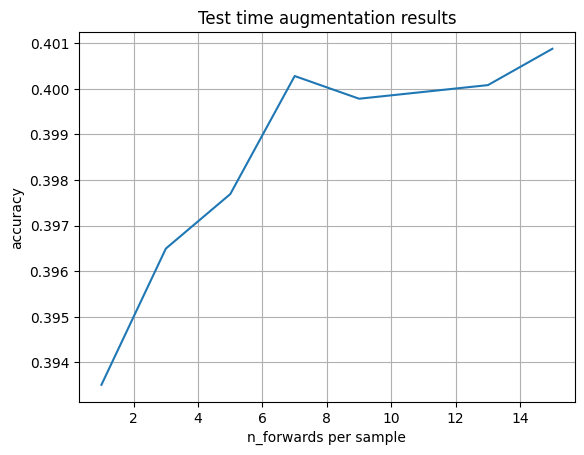

In [56]:
plt.plot(n_forwards, tta_accuracy)
plt.grid()
plt.xlabel('n_forwards per sample')
plt.ylabel('accuracy')
plt.title('Test time augmentation results')

Normally you should get 1-2% improvement of accuracy here.

Качество действительно подросло, хоть чутка поменьше, чем было заявлено. Предполагаю, что это может быть связано с тем, что модель мы немного поменьше обучали, чем 30 эпох, поэтому нейронка еще не супер хорошо выучила аугментации

Интересно попробовать с более переобученной моделью. Возьмем все ту же архитектуру и обучим уже 20+ эпох

In [20]:
model = create_vgg_like_network(config=[[16,16], [32,32,32,32], [64, 64, 64, 64], [128, 128, 128, 128]])
model = model.to(device)
opt = torch.optim.Adam(model.parameters())
train_loop(model, opt, train_batch_gen, val_batch_gen, num_epochs=24)

100%|██████████| 1563/1563 [04:01<00:00,  6.48it/s]


Epoch 1 of 24 took 245.025s
  training loss (in-iteration): 	4.425455
  validation accuracy: 			8.62 %


100%|██████████| 1563/1563 [03:58<00:00,  6.55it/s]


Epoch 2 of 24 took 243.497s
  training loss (in-iteration): 	3.742741
  validation accuracy: 			15.39 %


100%|██████████| 1563/1563 [03:59<00:00,  6.54it/s]


Epoch 3 of 24 took 243.373s
  training loss (in-iteration): 	3.390241
  validation accuracy: 			23.84 %


100%|██████████| 1563/1563 [03:55<00:00,  6.64it/s]


Epoch 4 of 24 took 238.748s
  training loss (in-iteration): 	3.161447
  validation accuracy: 			26.57 %


100%|██████████| 1563/1563 [04:03<00:00,  6.43it/s]


Epoch 5 of 24 took 246.336s
  training loss (in-iteration): 	2.982368
  validation accuracy: 			29.73 %


100%|██████████| 1563/1563 [04:00<00:00,  6.50it/s]


Epoch 6 of 24 took 244.168s
  training loss (in-iteration): 	2.846542
  validation accuracy: 			30.75 %


100%|██████████| 1563/1563 [04:01<00:00,  6.47it/s]


Epoch 7 of 24 took 245.233s
  training loss (in-iteration): 	2.722586
  validation accuracy: 			33.22 %


100%|██████████| 1563/1563 [03:59<00:00,  6.53it/s]


Epoch 8 of 24 took 243.282s
  training loss (in-iteration): 	2.617931
  validation accuracy: 			33.05 %


100%|██████████| 1563/1563 [03:58<00:00,  6.55it/s]


Epoch 9 of 24 took 241.931s
  training loss (in-iteration): 	2.535278
  validation accuracy: 			33.39 %


100%|██████████| 1563/1563 [04:02<00:00,  6.45it/s]


Epoch 10 of 24 took 245.661s
  training loss (in-iteration): 	2.455191
  validation accuracy: 			38.14 %


100%|██████████| 1563/1563 [04:00<00:00,  6.50it/s]


Epoch 11 of 24 took 244.056s
  training loss (in-iteration): 	2.383944
  validation accuracy: 			37.19 %


100%|██████████| 1563/1563 [03:59<00:00,  6.53it/s]


Epoch 12 of 24 took 243.070s
  training loss (in-iteration): 	2.322421
  validation accuracy: 			39.22 %


100%|██████████| 1563/1563 [04:03<00:00,  6.43it/s]


Epoch 13 of 24 took 246.572s
  training loss (in-iteration): 	2.259656
  validation accuracy: 			39.76 %


100%|██████████| 1563/1563 [03:59<00:00,  6.54it/s]


Epoch 14 of 24 took 242.450s
  training loss (in-iteration): 	2.216094
  validation accuracy: 			38.26 %


100%|██████████| 1563/1563 [03:55<00:00,  6.64it/s]


Epoch 15 of 24 took 239.566s
  training loss (in-iteration): 	2.168168
  validation accuracy: 			41.05 %


100%|██████████| 1563/1563 [03:55<00:00,  6.64it/s]


Epoch 16 of 24 took 238.598s
  training loss (in-iteration): 	2.117902
  validation accuracy: 			41.93 %


100%|██████████| 1563/1563 [03:52<00:00,  6.73it/s]


Epoch 17 of 24 took 236.801s
  training loss (in-iteration): 	2.074096
  validation accuracy: 			40.89 %


100%|██████████| 1563/1563 [03:58<00:00,  6.54it/s]


Epoch 18 of 24 took 242.380s
  training loss (in-iteration): 	2.035410
  validation accuracy: 			42.54 %


100%|██████████| 1563/1563 [04:08<00:00,  6.30it/s]


Epoch 19 of 24 took 252.451s
  training loss (in-iteration): 	2.001731
  validation accuracy: 			43.59 %


100%|██████████| 1563/1563 [03:59<00:00,  6.54it/s]


Epoch 20 of 24 took 243.006s
  training loss (in-iteration): 	1.964953
  validation accuracy: 			43.57 %


100%|██████████| 1563/1563 [03:58<00:00,  6.54it/s]


Epoch 21 of 24 took 242.195s
  training loss (in-iteration): 	1.929113
  validation accuracy: 			43.13 %


100%|██████████| 1563/1563 [04:02<00:00,  6.45it/s]


Epoch 22 of 24 took 246.157s
  training loss (in-iteration): 	1.896510
  validation accuracy: 			43.44 %


100%|██████████| 1563/1563 [03:59<00:00,  6.52it/s]


Epoch 23 of 24 took 243.275s
  training loss (in-iteration): 	1.863430
  validation accuracy: 			44.26 %


100%|██████████| 1563/1563 [04:03<00:00,  6.42it/s]


Epoch 24 of 24 took 246.756s
  training loss (in-iteration): 	1.835921
  validation accuracy: 			43.44 %


In [21]:
model_accuracy = eval_model(model, val_batch_gen)
print(f"Trained model accuracy: {model_accuracy}")

Trained model accuracy: 0.43441480891719747


In [22]:
n_forwards = [1]
tta_accuracy = [model_accuracy]
for i in [3, 5, 7, 9, 13, 15]:
    tta_accuracy.append(eval_model_with_tta(model, val_batch_gen, tta_transformations, n_transformations=i))
    n_forwards.append(i)
    print(f"Model accuracy with {n_forwards[-1]} forward runs is {tta_accuracy[-1]}")

100%|██████████| 157/157 [00:44<00:00,  3.56it/s]


Model accuracy with 3 forward runs is 0.44884554140127386


100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Model accuracy with 5 forward runs is 0.44914410828025475


100%|██████████| 157/157 [01:38<00:00,  1.60it/s]


Model accuracy with 7 forward runs is 0.44964171974522293


100%|██████████| 157/157 [02:06<00:00,  1.24it/s]


Model accuracy with 9 forward runs is 0.45272691082802546


100%|██████████| 157/157 [02:58<00:00,  1.14s/it]


Model accuracy with 13 forward runs is 0.4528264331210191


100%|██████████| 157/157 [03:27<00:00,  1.32s/it]

Model accuracy with 15 forward runs is 0.44884554140127386


Text(0.5, 1.0, 'Test time augmentation results')

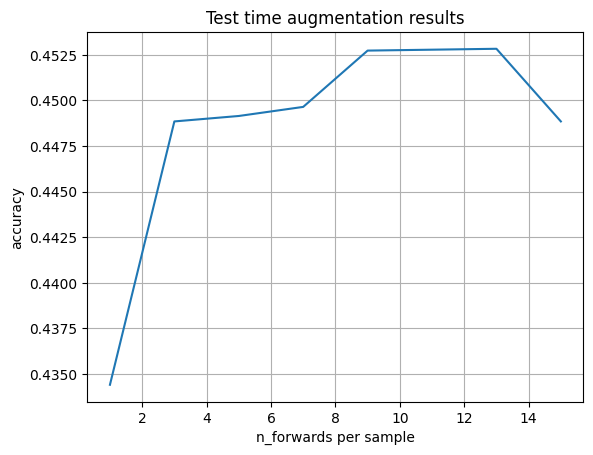

In [23]:
plt.plot(n_forwards, tta_accuracy)
plt.grid()
plt.xlabel('n_forwards per sample')
plt.ylabel('accuracy')
plt.title('Test time augmentation results')

И правда, на пике улучшение больше, чем на 1.5%, то есть для лучше обученной сети этот трюк работает лучше, так как аугментации выучились лучше